# For this project, I will adopt a script written by Jacob Linger on Medium ([Article 1](https://medium.com/@jacoblingerr/building-a-stock-option-valuation-model-with-python-part-i-faa7bc5be5b1), [Article 2](https://medium.com/@jacoblingerr/building-a-stock-option-valuation-model-with-python-part-ii-c93262d41d0b)), to build out a complete model for valuing options on equities and analyzing a portfolio of securities (equities, options, bonds, forwards). This model will:
# &emsp;&emsp; - Collect options data from Yahoo Finance
# &emsp;&emsp; - Create payoff diagrams of the desired portfolio
# &emsp;&emsp; - Simulate price changes to create simulated payoff probabilities
# &emsp;&emsp; - Calculate expected payout

## Import necessary packages

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from dfply import *
from ordered_set import OrderedSet
import random
from copy import copy

import yfinance as yf
from yahoo_fin.stock_info import *
from yahoo_fin.options import *

import math
import datetime as dt
from datetime import date
from datetime import datetime

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#from jupyterthemes import jt
!jt -t onedork

#### Set default plot attributes

In [3]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [17]:
plt.style.use(['seaborn-darkgrid'])
#mpl.rcParams['text.color'] = 'w'
#mpl.rcParams['axes.labelcolor'] = 'w'
#mpl.rcParams['xtick.color'] = 'w'
#mpl.rcParams['ytick.color'] = 'w'
mpl.rc('xtick', labelsize=18)    # fontsize of the tick labels
#mpl.rc('legend', color='black')
mpl.rc('ytick', labelsize=18)    # fontsize of the tick labels
mpl.rc('legend', fontsize=20)    # legend fontsize     
mpl.rc('axes', titlesize=20)     # fontsize of the axis title
mpl.rc('axes', labelsize=20)     # fontsize of the axis labels
mpl.rc('figure', titlesize=25)

## Generate list of all stocks listed on the S&P 500

In [5]:
sp_list = tickers_sp500() # `tickers_sp500` from yahoo_fin
# Remove two tickers with a period in ticker
sp_list.remove('BF.B')
sp_list.remove('BRK.B')

In [6]:
len(sp_list)

503

## Generate DataFrame for options dataset

#### Select which contracts should be collected

In [7]:
expiration = get_expiration_dates(sp_list[0])[1]   # Select front contract, second contract, etc.
options_df = pd.DataFrame()                        # Create empty df to store data in 

#### Initiate for loop to collect call option data for all stocks listed on the SP500

In [8]:
get_calls(stock, expiration)

NameError: name 'stock' is not defined

In [9]:
for stock in sp_list[1:50]:
    try:
        price = get_live_price(stock)              # `get_live_price` from yahoo_fin
        option = get_calls(stock, expiration)      # `get_live_price` from yahoo_fin, creates df with call data for selected ticker 
        option['CurrentPrice'] = price             # Assign price to temp options df 
        option['Ticker'] = stock                   # Assign key value with ticker string
        option['DateExp'] = expiration             # Assign key value with expiration date
        options_df = options_df.append(option)     # Append modified temp options df to master df
        print(stock, round(price,3))
    except:
        # If no results come from get_live_price, or get_calls, then resume next iteration
        print(f'Option contract not available on {str(expiration)} for {stock}')
        pass

AAL 13.2
AAP 155.32
AAPL 116.97
ABBV 87.7
ABC 96.86
ABMD 273.56
ABT 109.65
ACN 228.69
ADBE 502.16
ADI 123.33
ADM 48.97
ADP 149.85
ADSK 237.5
AEE 82.05
AEP 89.82
AES 19.32
AFL 38.1
AIG 29.95
AIV 36.76
AIZ 125.57
AJG 108.55
AKAM 112.53
ALB 96.03
ALGN 328.64
ALK 38.69
ALL 92.86
ALLE 103.99
ALXN 124.52
AMAT 63.29
AMCR 11.42
AMD 83.1
AME 106.94
AMGN 236.7
AMP 170.34
AMT 244.68
AMZN 3286.65
ANET 227.61
ANSS 336.82
ANTM 294.41
AON 209.19
AOS 57.19
APA 9.67
APD 300.6
APH 113.49
APTV 98.06
ARE 165.15
ATO 96.51
ATVI 78.21
AVB 158.34


#### Clean up master options DataFrame

In [10]:
options_df = options_df[['Contract Name', 'Strike', 'Bid', 'Ask', 'CurrentPrice', 'Volume', 'Open Interest', 'Ticker', 'DateExp']]

#### Calculate average price of individual options (Bid + Ask / 2) to estimate total costs for each option

In [11]:
options_df.replace('-','0',inplace=True)
options_df.loc[:,'AvgPrice'] = (pd.to_numeric(options_df.Bid) + pd.to_numeric(options_df.Ask)) / 2
options_df.loc[:,'OptionCost'] = options_df['AvgPrice'] * 100

#### Define function to calculate `%` & `$ $` payoffs for a given price change level  

In [12]:
def pricePCTpayoff(x, row):
    # input x as a decimal 
    newPrice = row.CurrentPrice * (1 + x)
    
    if newPrice >= row.Strike:
        return 100*newPrice - 100*row.Strike - row.OptionCost
    else:
        return 0-row.OptionCost
    
def priceDOLpayoff(d, row):
    # input d as a float
    newPrice = d
    
    if newPrice >= row.Strike:
        return 100*newPrice - 100*row.Strike - row.OptionCost
    else:
        return 0-row.OptionCost

## Generate payouts for one selected call option based on % price changes

#### Add in column to `options_df` for the absolute value of strike - current price. The minimum value of this series will correspond to the contract closest to being ATM.

In [13]:
options_df['K-S'] = abs(options_df.Strike - options_df.CurrentPrice)

#### Input ticker for options we'd like to examine

In [14]:
# Ticker of equity we'd like to analyze
tick = 'AAPL' 
# Indexer value used to select a specific contract from all available strikes
contract = options_df[options_df.Ticker == tick][['K-S']].idxmin().max()

In [19]:
contract = 10

#### Initiate loop to calculate payoffs and plot the results

In [ ]:
option

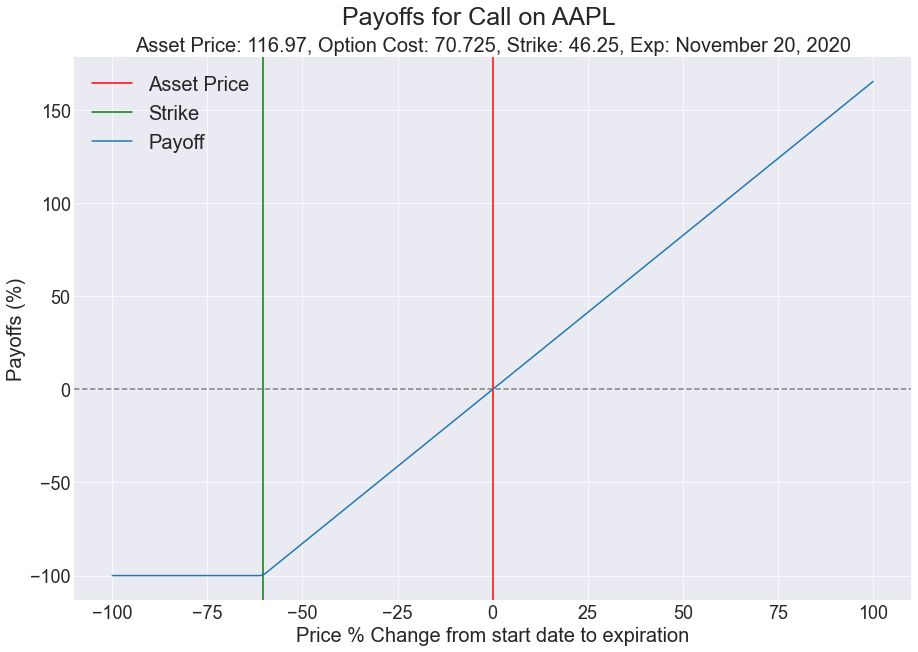

In [20]:
xs = np.arange(-100,101,1)
payoffs = []
option = options_df[options_df.Ticker == tick].iloc[contract]

for x in xs:
    pct = x * 0.01
    payoff = pricePCTpayoff(pct, option) / option.OptionCost
    payoffs.append(100*payoff)

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

plt.axvline(0, c='r', label="Asset Price")
plt.axvline(((option.Strike/option.CurrentPrice.min())-1)*100, c='g', label="Strike")
plt.axhline(0, c='grey', ls='--')

plt.plot(xs, payoffs, label="Payoff")

plt.xlabel('Price % Change from start date to expiration')
plt.ylabel('Payoffs (%)')
plt.suptitle(f"Payoffs for Call on {option.Ticker}", y = 0.95)
plt.title(f"Asset Price: {round(option.CurrentPrice,2)}, Option Cost: {option.AvgPrice}, Strike: {option.Strike}, Exp: {option.DateExp}")
plt.legend()

#plt.setp(legend.get_texts(), color='w')


plt.show()

## Generate payouts for one selected call option based on `$` price changes

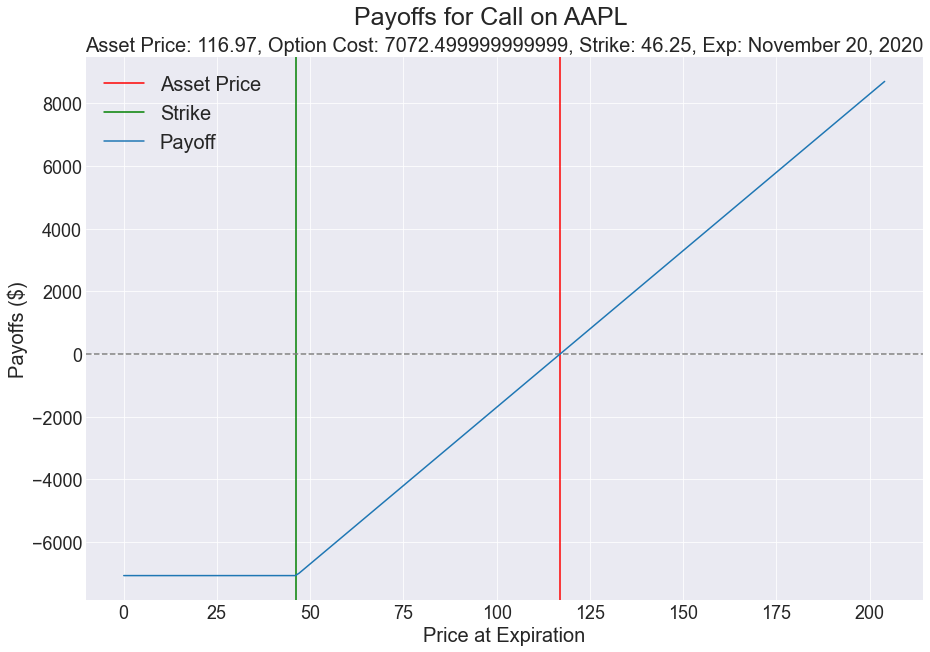

In [22]:
payoffs = []
option = options_df[options_df.Ticker == tick].iloc[contract]
xs = np.arange(0,
               round(option.CurrentPrice + .75*option.CurrentPrice,0),
               round(option.CurrentPrice/100,0))

for x in xs:
    payoff = priceDOLpayoff(x, option)
    payoffs.append(payoff)

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

plt.axvline(option.CurrentPrice, c='r', label="Asset Price")
plt.axvline(option.Strike, c='g', label="Strike")
plt.axhline(0, c='grey', ls='--')

plt.plot(xs, payoffs, label="Payoff")

plt.xlabel('Price at Expiration')
plt.ylabel('Payoffs ($)')
plt.suptitle(f"Payoffs for Call on {option.Ticker}", y = 0.95)
plt.title(f"Asset Price: {round(option.CurrentPrice,2)}, Option Cost: {option.OptionCost}, Strike: {option.Strike}, Exp: {option.DateExp}")
plt.legend()

plt.show()

## Generate probability distribution of price changes

#### Define function to randomly sample stock prices for selcted tickers

In [23]:
def delta_dist(ticker, duration, sample_size):
    stock = get_data(ticker).close
    dates = list(stock.index)
    duration = int(duration)
    
    if len(dates) < sample_size:
        print(f"Sample size of {sample_size} exceeds number of days prices are listed.")
        print(f"Sample resized to size {len(dates)}.")    
        sample_size = len(dates)
    else:
        sample_size = int(sample_size)
    
    delta = []
    check = []
    for s in range(sample_size):
        try:
            x = random.randint(0, len(dates)-1)
            while x in check:
                x = random.randint(0, len(dates)-1)
            check.append(x)
            start = stock[x]
            stop = stock[x + duration]
            diffPct = (stop/start) - 1
            delta.append(diffPct)
        except:
            pass
        
    return delta

#### Generate `N` random samples of price changes over a specified `duration`

In [24]:
duration = 14 #days
N = 200

<ipython-input-25-7dbebfd68d99>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-25-7dbebfd68d99>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


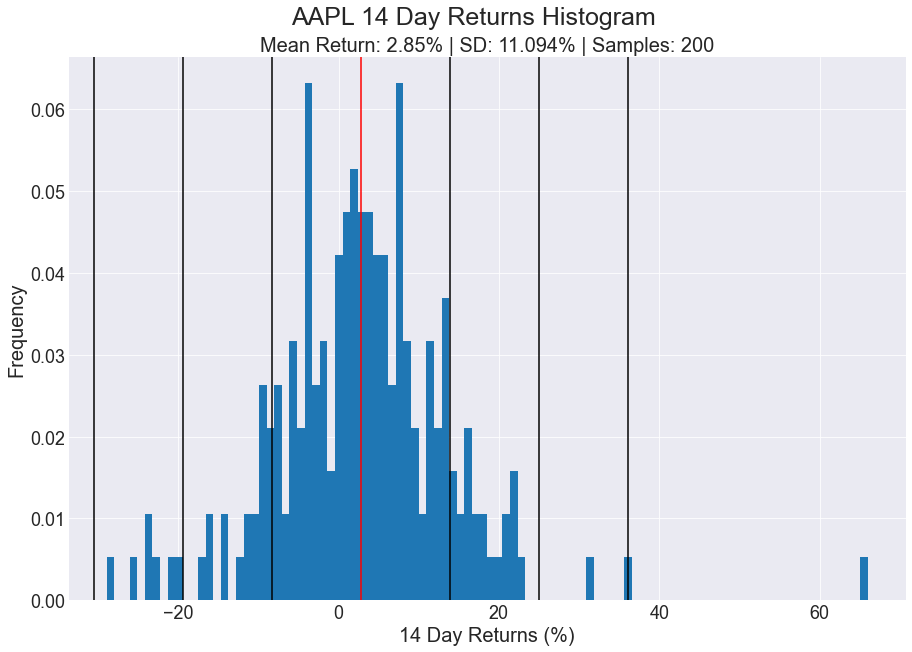

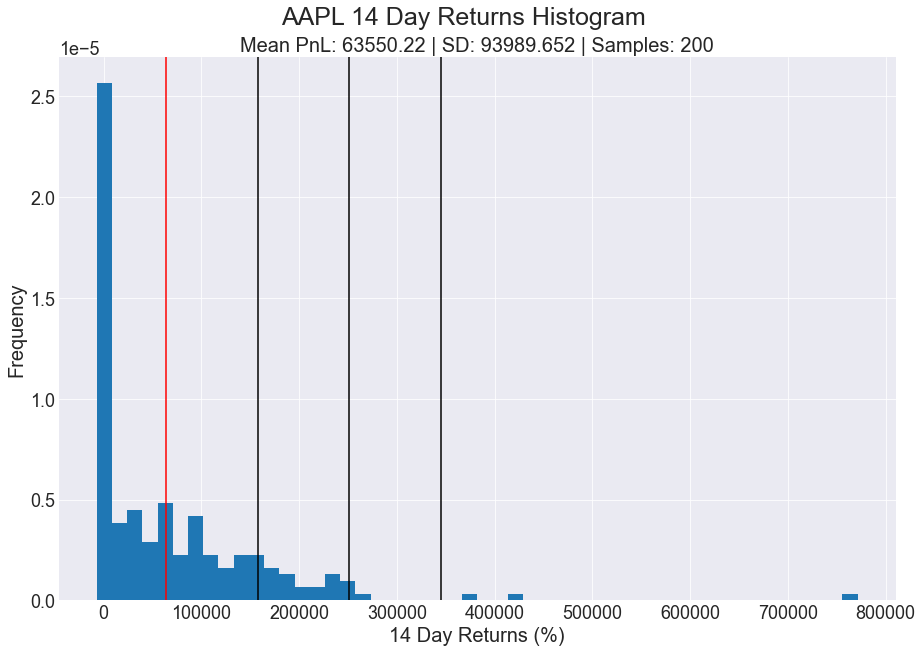

In [25]:
changes = delta_dist(tick, duration, N)
# ----------------------------------------------------------------
changes = [x*100 for x in changes if str(x) != 'nan']

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

a = plt.hist(changes, bins=100, density=True)

mean = np.mean(np.array(changes))
sd = np.std(np.array(changes))
plt.axvline(mean, c='red')

for i in range(-3,4):
    if i != 0:
        plt.axvline(mean + (i * sd), c='black')

plt.xlabel(f"{duration} Day Returns (%)")
plt.ylabel('Frequency')
plt.suptitle(f"{option.Ticker} {duration} Day Returns Histogram", y = 0.95)
title = f"Mean Return: {round(mean,2)}% | SD: {round(sd,3)}% | Samples: {len(changes)}"

plt.title(title)
        
fig.show()

# ----------------------------------------------------------------
changes = [pricePCTpayoff(x, option) for x in changes if str(x) != 'nan']

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

a = plt.hist(changes, bins=50, density=True)

mean = np.mean(np.array(changes))
sd = np.std(np.array(changes))
plt.axvline(mean, c='red')

for i in range(1,4):
    if i != 0:
        plt.axvline(mean + (i * sd), c='black')

plt.xlabel(f"{duration} Day Returns (%)")
plt.ylabel('Frequency')
plt.suptitle(f"{option.Ticker} {duration} Day Returns Histogram", y = 0.95)
title = f"Mean PnL: {round(mean,2)} | SD: {round(sd,3)} | Samples: {len(changes)}"

plt.title(title)
        
fig.show()


<ipython-input-26-e8fdb0f1094c>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


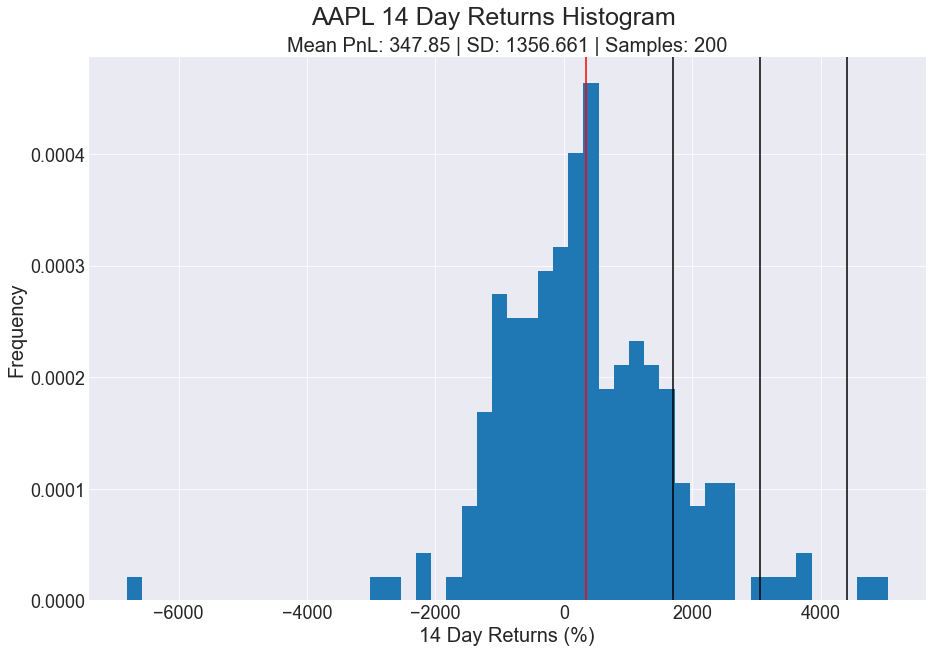

In [26]:
changes = delta_dist(tick, duration, N)
changes = [pricePCTpayoff(x, option) for x in changes if str(x) != 'nan']

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

a = plt.hist(changes, bins=50, density=True)

mean = np.mean(np.array(changes))
sd = np.std(np.array(changes))
plt.axvline(mean, c='red')

for i in range(1,4):
    if i != 0:
        plt.axvline(mean + (i * sd), c='black')

plt.xlabel(f"{duration} Day Returns (%)")
plt.ylabel('Frequency')
plt.suptitle(f"{option.Ticker} {duration} Day Returns Histogram", y = 0.95)
title = f"Mean PnL: {round(mean,2)} | SD: {round(sd,3)} | Samples: {len(changes)}"

plt.title(title)
        
fig.show()